In [1]:
import os
import numpy as np
import pandas as pd
import json
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import keras
import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import *
import keras.backend as K
import keras.optimizers as Optimizers
import keras.callbacks
from keras.utils import to_categorical

Using TensorFlow backend.


In [43]:
data_path = "data"
labels_file = "bboxes.json"
img_size = (256, 256, 3)

In [44]:
colors = [(255, 0, 0),
           (0, 0, 255),
           (0, 255, 0),
           (0, 255, 255),
           (0, 102, 0),
           (255, 0, 255),
           (255, 255, 0),
           (255, 102, 255),
           (0, 51, 102),
           (51, 153, 255)]

In [45]:
class_nb = 2
nb_boxes = 1
grid_w = 4
grid_h = 4
cell_w = img_size[0] // grid_w
cell_h = img_size[1] // grid_h
img_w = grid_w * cell_w
img_h = grid_h * cell_h

In [83]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, data, data_path, class_nb, batch_size=32, shuffle=False, preprocess=None):
        super().__init__()
        self.data = data
        self.file_names = np.array(list(self.data.keys()))
        self.class_nb = class_nb
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.data_path = data_path
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def preprocess(X):
        return X
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size, img_size[1], img_size[0], img_size[2]), dtype=np.float32)
        y = np.empty((self.batch_size, grid_w * grid_h, (class_nb + nb_boxes * 5)), dtype=np.float32)
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        for i, f in enumerate([self.file_names[idx] for idx in indexes]):
            X[i,] = Image.open(os.path.join(self.data_path, f)).resize((img_size[0], img_size[1]))
            X[i,] = np.array(X[i,]) / 255.0
            y[i,] = build_yolo_out(self.data[f])
        if self.preprocess!=None: 
            X = self.preprocess(X)
        return X, y

In [113]:
def rect_is_in_cell(rect, row, col):
    if rect[0] * img_w > col * cell_w and rect[0] * img_w <= col * cell_w + cell_w and \
        rect[1] * img_h > row * cell_h and rect[1] * img_h <= row * cell_h + cell_h:
            return True
    return False

def build_yolo_out(data):
    y_t = []
    for row in range(grid_h):
        for col in range(grid_w):
            found = False
            for class_id in data:
                for rect in data[class_id]:
                    if rect_is_in_cell(rect, row, col):
                        #class
                        c_t = list(to_categorical(int(class_id)+1, num_classes=class_nb))
                        #define center position and w h
                        x = rect[0] * img_w
                        y = rect[1] * img_h
                        rel_x = (x - (col * cell_w)) / cell_w
                        rel_y = (y - (row * cell_h)) / cell_h
                        #rel_x = x / cell_w
                        #rel_y = y / cell_h
                        [x, y, w, h] = [rel_x, rel_y, rect[2], rect[3]]
                        #confidence
                        conf_t = [1]
                        elt = []
                        elt += c_t
                        for b in range(nb_boxes):
                            elt += [x, y, w, h] + conf_t
                        y_t.append(elt)
                        found = True
            if found == False:
                #class
                c_t = list(to_categorical(0, num_classes=class_nb))
                #define center position and w h
                rel_x = (cell_w / 2) / cell_w
                rel_y = (cell_h / 2) / cell_h
                #rel_x = ((col * cell_w) + (cell_w / 2)) / cell_w
                #rel_y = ((row * cell_h) + (cell_h / 2)) / cell_h
                [x, y, w, h] = [rel_x, rel_y, cell_w / img_w, cell_h / img_h]
                #confidence
                conf_t = [0]
                elt = []
                elt += c_t
                for b in range(nb_boxes):
                    elt += [x, y, w, h] + conf_t
                y_t.append(elt)
            
    return y_t

In [114]:
with open(labels_file) as f:
    dict_data = json.load(f)
                
batch_size = 1
train_batches = DataGenerator(dict_data, data_path, class_nb, batch_size=batch_size)

c:\users\rock_\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


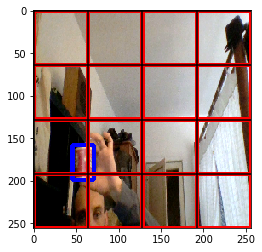

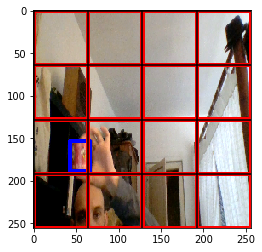

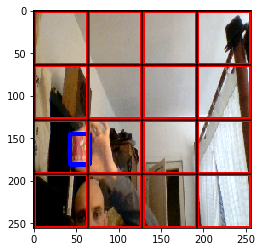

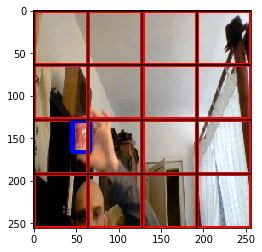

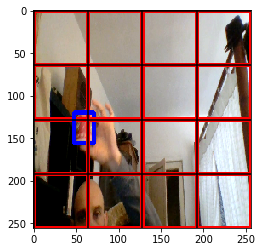

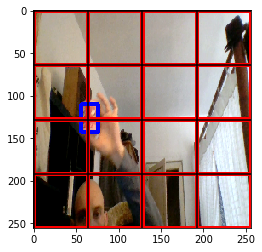

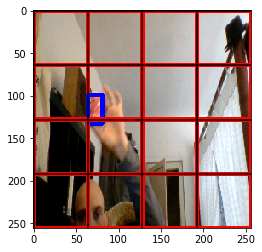

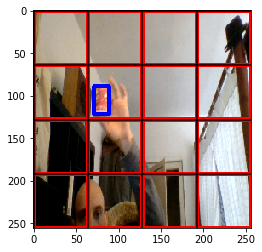

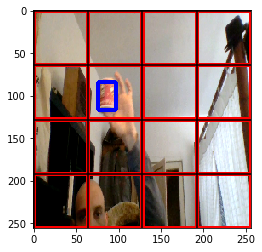

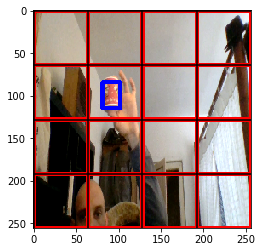

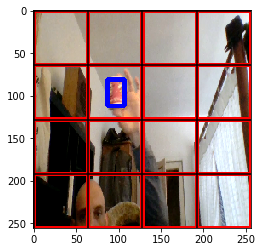

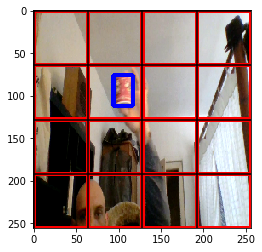

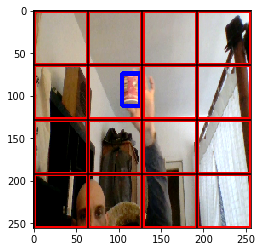

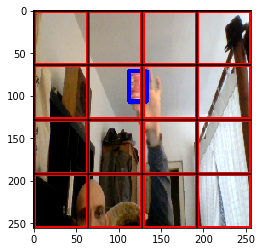

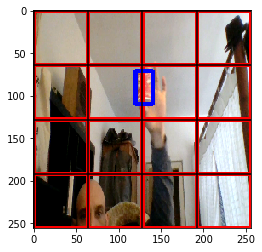

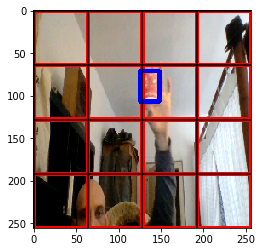

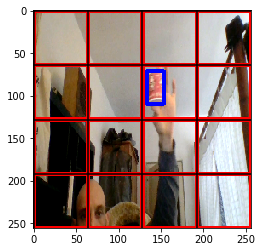

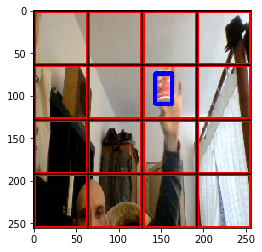

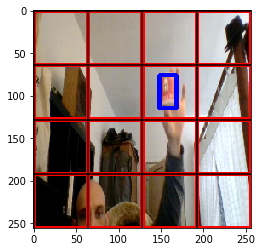

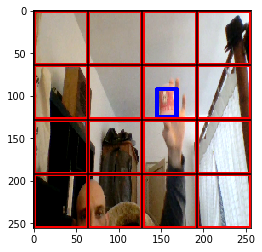

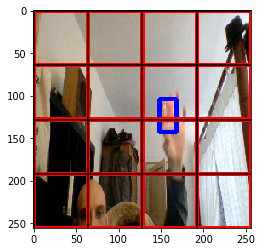

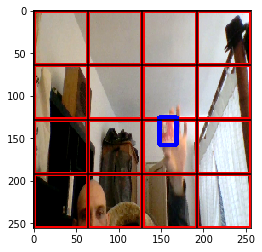

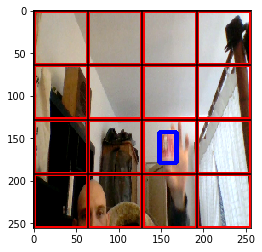

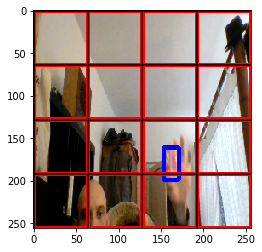

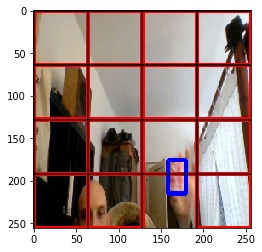

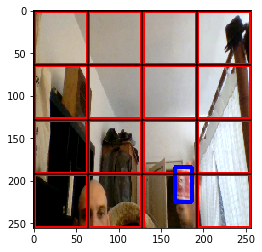

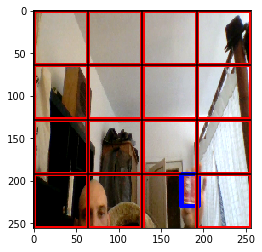

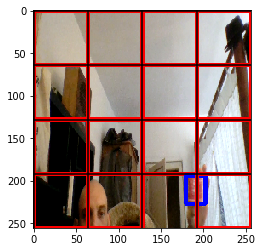

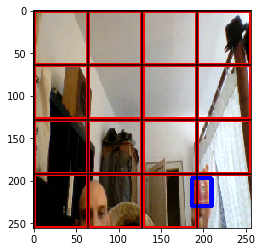

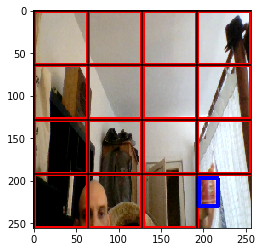

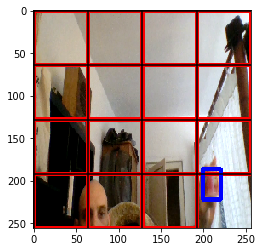

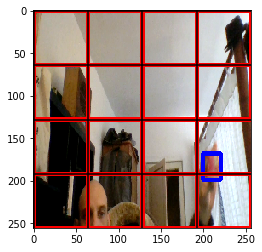

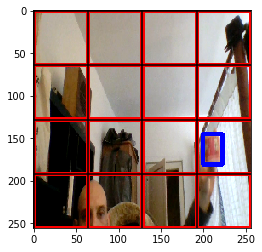

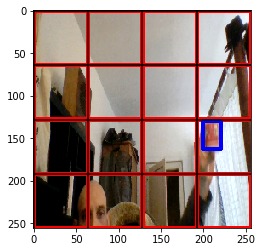

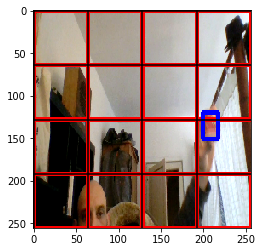

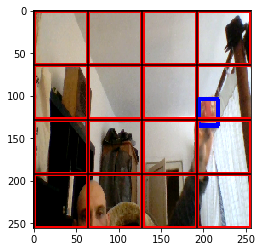

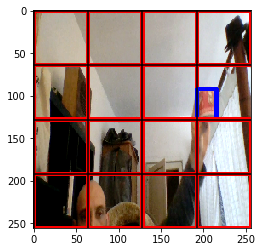

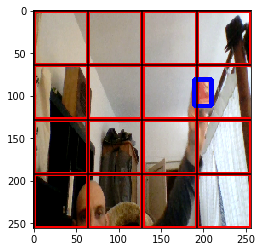

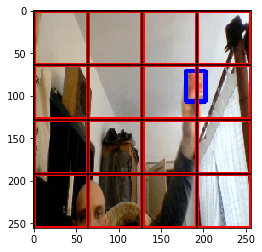

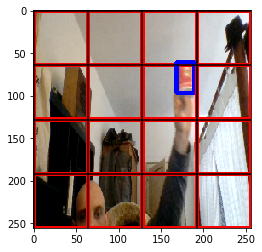

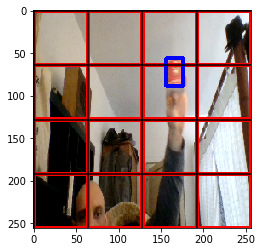

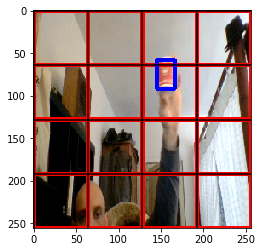

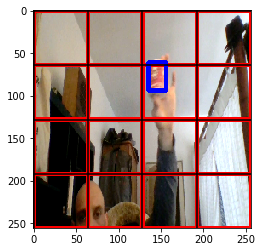

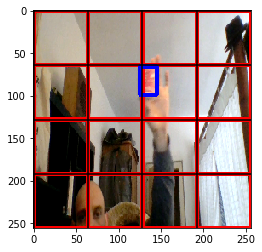

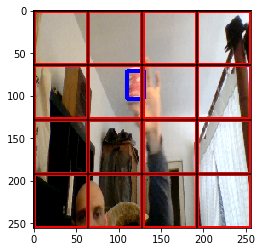

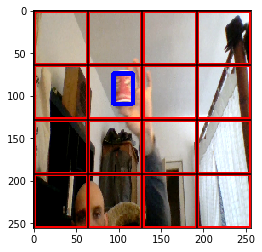

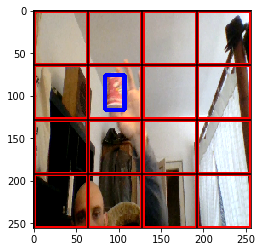

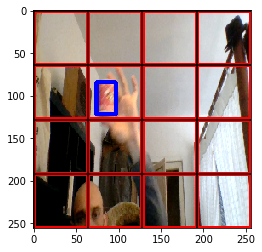

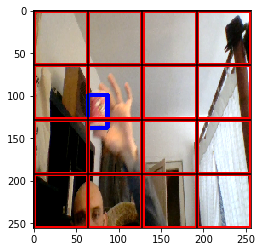

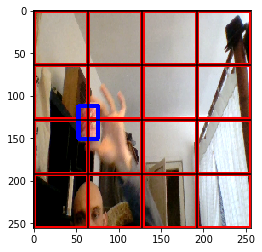

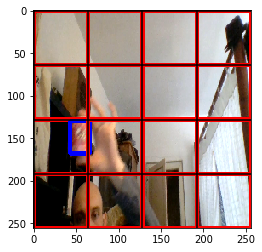

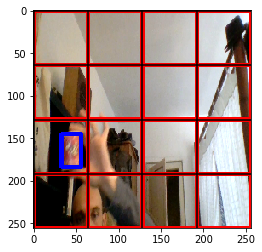

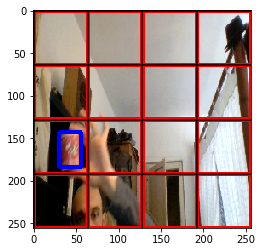

In [115]:
for batch in train_batches:
    for i in range(batch_size):
        img = (batch[0][i,] * 255).astype('uint8')
        for n, label in enumerate(batch[1][i,]):
            row = int(n / grid_h)
            col = n - (row * grid_w)
            x = (label[class_nb + 0] * cell_w) + (col * cell_w)
            y = (label[class_nb + 1] * cell_h) + (row * cell_h) 
            pt1 = (int(x - (label[class_nb + 2] * img_w / 2)), \
                   int(y - (label[class_nb + 3] * img_h / 2)))
            pt2 = (int(x + (label[class_nb + 2] * img_w / 2)), \
                   int(y + (label[class_nb + 3] * img_h / 2)))
            cv2.rectangle(img, pt1, pt2, colors[np.argmax(label[:class_nb])], thickness=3)
        plt.figure()
        plt.imshow(img)
        for row in range(grid_w):
            plt.axvline(x=row*cell_w,color='black')
        for col in range(grid_h):
            plt.axhline(y=col*cell_h,color='black')

In [116]:
def custom_loss(y_true, y_pred):
    grid = np.array([[[float(x),float(y)]] * nb_boxes for y in range(grid_h) for x in range(grid_w)])

    y_true_class = y_true[...,1:class_nb]
    y_pred_class = y_pred[...,1:class_nb]

    pred_boxes = K.reshape(y_pred[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    true_boxes = K.reshape(y_true[...,class_nb:], (-1, grid_w * grid_h, nb_boxes, 5))
    
    y_pred_xy   = pred_boxes[...,0:2] + K.variable(grid)
    y_pred_wh   = pred_boxes[...,2:4]
    y_pred_conf = pred_boxes[...,4]

    y_true_xy   = true_boxes[...,0:2]
    y_true_wh   = true_boxes[...,2:4]
    y_true_conf = true_boxes[...,4]

    clss_loss  = K.sum(K.square(y_true_class - y_pred_class), axis=-1)
    xy_loss    = K.sum(K.sum(K.square(y_true_xy - y_pred_xy),axis=-1)*y_true_conf, axis=-1)
    wh_loss    = K.sum(K.sum(K.square(K.sqrt(y_true_wh) - K.sqrt(y_pred_wh)), axis=-1)*y_true_conf, axis=-1)

    # when we add the confidence the box prediction lower in quality but we gain the estimation of the quality of the box
    # however the training is a bit unstable

    # minimum distance between boxes distance between the two center
    intersect_wh = K.maximum(K.zeros_like(y_pred_wh), (y_pred_wh + y_true_wh)/2 - K.abs(y_pred_xy - y_true_xy) )
    intersect_area = intersect_wh[...,0] * intersect_wh[...,1]
    true_area = y_true_wh[...,0] * y_true_wh[...,1]
    pred_area = y_pred_wh[...,0] * y_pred_wh[...,1]
    union_area = pred_area + true_area - intersect_area
    iou = intersect_area / union_area

    conf_loss = K.sum(K.square(y_true_conf*iou - y_pred_conf)*y_true_conf, axis=-1)

    return clss_loss + xy_loss + wh_loss + conf_loss

In [117]:
K.clear_session()

img_in = Input(shape=(img_size[1], img_size[0], img_size[2]), name='img_in')

x = Conv2D(64, (7, 7), strides=2, padding='same')(img_in)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(128, (1, 1), padding='same')(x)
x = Conv2D(256, (3, 3), padding='same')(x)
x = Conv2D(256, (1, 1), padding='same')(x)
x = Conv2D(512, (1, 1), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = Dropout(0.3)(x)
x = Conv2D(256, (1, 1), padding='same')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = Conv2D(256, (1, 1), padding='same')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = Conv2D(256, (1, 1), padding='same')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = Conv2D(256, (1, 1), padding='same')(x)
x = Conv2D(512, (3, 3), padding='same')(x)
x = Conv2D(512, (1, 1), padding='same')(x)
x = Conv2D(1024, (3, 3), padding='same')(x)
x = keras.layers.LeakyReLU(alpha=0.3)(x)
x = MaxPooling2D(pool_size=(2, 2), strides=2)(x)
x = Conv2D(512, (1, 1), padding='same')(x)
x = Conv2D(1024, (3, 3), padding='same')(x)
x = Conv2D(512, (1, 1), padding='same')(x)
x = Conv2D(1024, (3, 3), padding='same')(x)
x = Conv2D(1024, (3, 3), padding='same')(x)
x = Conv2D(1024, (3, 3), strides=2, padding='same')(x)
x = Conv2D(1024, (3, 3), padding='same')(x)
x = Conv2D(1024, (3, 3), padding='same')(x)


x = Flatten()(x)
x = Dense(256, activation='sigmoid')(x)
x = Dense(grid_w * grid_h * (class_nb + nb_boxes * 5), activation='sigmoid')(x)
out = Reshape((grid_w * grid_h, (class_nb + nb_boxes * 5)))(x)

model = Model(inputs=img_in, outputs=out)

model.compile(optimizer = "adadelta", loss = custom_loss)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      9472      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       8320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       6579

In [118]:
model_name = "model.h5"
#save best model if model improved
best_checkpoint = keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [119]:
idx = int(0.8*len(dict_data))
train_data = {k: dict_data[k] for k in list(dict_data)[:idx]}
val_data = {k: dict_data[k] for k in list(dict_data)[idx:]}

batch_size = 8
train_batches = DataGenerator(train_data, data_path, class_nb, batch_size=batch_size, shuffle=True)
val_batches = DataGenerator(val_data, data_path, class_nb, batch_size=batch_size)

history = model.fit_generator(train_batches, validation_data = val_batches, epochs = 20, verbose=1, callbacks=[best_checkpoint])

Epoch 1/20
5/5 [==============================] - 35s 7s/step - loss: 0.6300 - val_loss: 0.3016

Epoch 00001: val_loss improved from inf to 0.30162, saving model to model.h5
Epoch 2/20
5/5 [==============================] - 34s 7s/step - loss: 0.5388 - val_loss: 0.4586

Epoch 00002: val_loss did not improve from 0.30162
Epoch 3/20
5/5 [==============================] - 35s 7s/step - loss: 0.6416 - val_loss: 0.3305

Epoch 00003: val_loss did not improve from 0.30162
Epoch 4/20
5/5 [==============================] - 37s 7s/step - loss: 0.5136 - val_loss: 0.2538

Epoch 00004: val_loss improved from 0.30162 to 0.25385, saving model to model.h5
Epoch 5/20
5/5 [==============================] - 40s 8s/step - loss: 0.4386 - val_loss: 0.2357

Epoch 00005: val_loss improved from 0.25385 to 0.23570, saving model to model.h5
Epoch 6/20
5/5 [==============================] - 42s 8s/step - loss: 0.4246 - val_loss: 0.2297

Epoch 00006: val_loss improved from 0.23570 to 0.22965, saving model to model

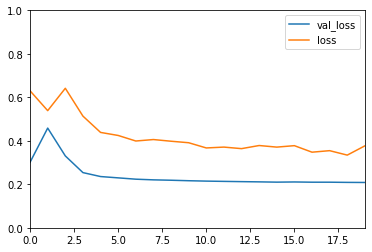

In [120]:
#print History graph
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot(ylim=(0,1))

[0.4579222  0.03013343 0.46375686 0.23300028 0.7335473  0.39976913
 0.18370986]
[0.429748   0.050942   0.689422   0.7747916  0.38816527 0.51598114
 0.37973064]
[0.8096146  0.03585336 0.6309862  0.16398665 0.82377744 0.23656484
 0.13101465]
[0.40051323 0.0362823  0.7079917  0.16437864 0.66412604 0.25882024
 0.4859799 ]
[0.18352672 0.03344622 0.30450296 0.58814615 0.5345954  0.27935612
 0.65114576]
[0.23957747 0.22354093 0.01626039 0.01294866 0.07910579 0.13204253
 0.05640274]
[0.3599524  0.2412928  0.0108605  0.01515165 0.08326495 0.14089918
 0.04687914]
[0.46970907 0.08342665 0.01510507 0.02798933 0.11187148 0.14364225
 0.07479355]
[0.43309656 0.11716357 0.8799248  0.01012865 0.09409279 0.14598581
 0.08966035]
[0.308587   0.05140674 0.7238967  0.64312947 0.5327997  0.4167192
 0.58781326]
[0.51418036 0.07192543 0.01847106 0.01586398 0.10011765 0.15472132
 0.09060079]
[0.68858975 0.10221499 0.02047664 0.01845139 0.0889107  0.13427594
 0.08590564]
[0.40488377 0.02854493 0.47490758 0.40249

[0.4579222  0.03013343 0.46375686 0.23300028 0.7335473  0.39976913
 0.18370986]
[0.429748   0.050942   0.689422   0.7747916  0.38816527 0.51598114
 0.37973064]
[0.8096146  0.03585336 0.6309862  0.16398665 0.82377744 0.23656484
 0.13101465]
[0.40051323 0.0362823  0.7079917  0.16437864 0.66412604 0.25882024
 0.4859799 ]
[0.18352672 0.03344622 0.30450296 0.58814615 0.5345954  0.27935612
 0.65114576]
[0.23957747 0.22354093 0.01626039 0.01294866 0.07910579 0.13204253
 0.05640274]
[0.3599524  0.2412928  0.0108605  0.01515165 0.08326495 0.14089918
 0.04687914]
[0.46970907 0.08342665 0.01510507 0.02798933 0.11187148 0.14364225
 0.07479355]
[0.43309656 0.11716357 0.8799248  0.01012865 0.09409279 0.14598581
 0.08966035]
[0.308587   0.05140674 0.7238967  0.64312947 0.5327997  0.4167192
 0.58781326]
[0.51418036 0.07192543 0.01847106 0.01586398 0.10011765 0.15472132
 0.09060079]
[0.68858975 0.10221499 0.02047664 0.01845139 0.0889107  0.13427594
 0.08590564]
[0.40488377 0.02854493 0.47490758 0.40249

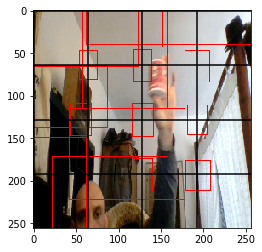

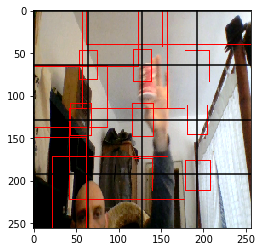

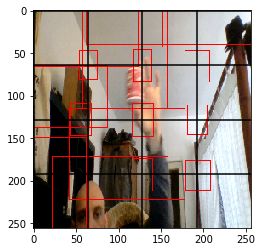

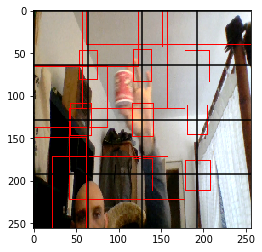

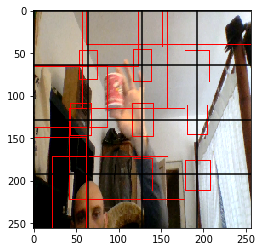

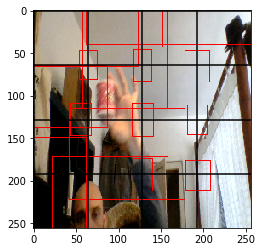

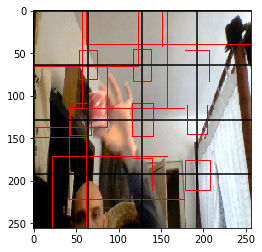

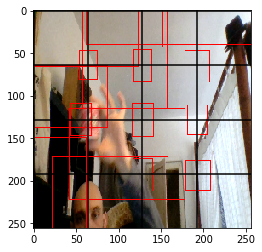

In [121]:
for batch in val_batches:
    for i in range(batch_size):
        img = batch[0][i,]
        pred = model.predict(img.reshape((1, img_size[1], img_size[0], img_size[2])))
        img = (img * 255).astype('uint8')
        for n, label in enumerate(pred[0]):
            print(label)
            col = n - (int(n / grid_h) * grid_w)
            row = int(n / grid_h)
            x = (label[class_nb + 0] * cell_w) + (col * cell_w)
            y = (label[class_nb + 1] * cell_h) + (row * cell_h)
            pt1 = (int(x - (label[class_nb + 2] * img_w / 2)), \
                   int(y - (label[class_nb + 3] * img_h / 2)))
            pt2 = (int(x + (label[class_nb + 2] * img_w / 2)), \
                   int(y + (label[class_nb + 3] * img_h / 2)))
            cv2.rectangle(img, pt1, pt2, colors[np.argmax(label[:class_nb])])
        plt.figure()
        plt.imshow(img)
        for row in range(grid_w):
            plt.axvline(x=row*cell_w,color='black')
        for col in range(grid_h):
            plt.axhline(y=col*cell_h,color='black')